# Задание
  1. Использовать DecisionTreeClassifier и DecisionTreeRegressor для наборов данных своего варианта.
  2. Использовать [ансамбли](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble) для наборов данных своего варианта:
    - BaggingClassifier
    - BaggingRegressor
    - GradientBoostingClassifier
    - GradientBoostingRegressor
    - StackingClassifier
    - StackingRegressor
  3. Попробовать для решения задачи регрессии и классификации одну из библиотек (на выбор): 
    - [Catboost](https://catboost.ai/en/docs/concepts/python-usages-examples), 
    - [XGBoost](https://xgboost.readthedocs.io/en/stable/get_started.html), 
    - [LightGBM](https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/simple_example.py)
  4. Реализовать обучения и вычисления дерева с использованием алгоритма CART для задачи регрессии и классификации.
  5. Доп. задание: реализовать(на выбор) бустинг или бэггинг.

In [36]:
from pathlib import Path
import os
import sys

sys.path.append(str(Path(os.getcwd()).parent))

In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from matplotlib import pyplot as plt
from sklearn.tree import plot_tree

## 1.1.1. Предобработка для классификации

In [78]:
table_classification = pd.read_csv("../data/neo_task_compleated.csv")
table_classification

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,0.016016,0.035813,56014.078517,1.024333e+06,26.10,False
1,0.030518,0.068240,7864.348060,3.268186e+07,24.70,False
2,0.055533,0.124177,55257.544508,6.538636e+07,23.40,False
3,0.019256,0.043057,41531.404722,1.260796e+07,25.70,False
4,0.139494,0.311918,67639.394481,7.130590e+07,21.40,False
...,...,...,...,...,...,...
90831,0.017561,0.039268,23264.740825,1.635007e+06,25.90,False
90832,0.110804,0.247765,24802.519406,3.351901e+07,21.90,False
90833,0.035039,0.078350,116288.999548,5.471396e+07,24.40,False
90834,0.044112,0.098637,45763.317060,2.694877e+07,23.90,False


In [79]:
X_classification = np.array(table_classification.drop(columns=['hazardous'], axis=1))
y_classification = np.array(table_classification['hazardous'])
columns = table_classification.drop(columns=['hazardous'], axis=1).columns

In [80]:
# Дисбаланс классов

rus = RandomUnderSampler()
X, y = rus.fit_resample(X_classification, y_classification)
print(X.shape, y.shape)

# X, y = X_classification, y_classification

(17680, 5) (17680,)


Без RandomUnderSampler очень плохие результаты у 2 класса!

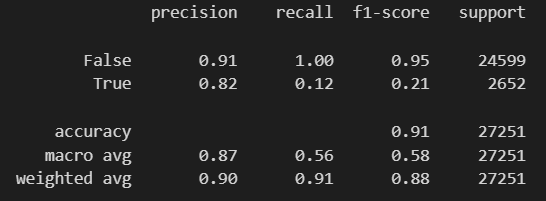

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True)

In [83]:
# Масштабирование

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_my_train, X_my_test, y_my_train, y_my_test = X_train, X_test, y_train, y_test

X_train

array([[-0.17454217, -0.17365261, -0.53150224,  0.97935634, -0.13784494],
       [-0.19339569, -0.19253052, -0.38897814,  0.63386826, -0.07739707],
       [ 0.16201592,  0.16334081, -0.34298716, -1.37488871, -0.79566004],
       ...,
       [-0.05628805, -0.05524553,  0.89694724,  1.50388142, -0.43652855],
       [-0.3765436 , -0.37591533, -0.61003836, -0.46058278,  1.13156041],
       [ 0.01420887,  0.01534257, -0.72320159, -0.69825118, -0.57164733]])

## 1.1.2. Обучение моделей решающих деревьев для классификации

In [43]:
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, StackingClassifier

In [44]:
# DecisionTreeClassifier

grid = {
    'max_depth': np.arange(3, 5, 1),
    'criterion': ["gini", "entropy", "log_loss"]
}

dt = GridSearchCV(DecisionTreeClassifier(), grid).fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.78      0.87      2652
        True       0.82      0.99      0.89      2652

    accuracy                           0.88      5304
   macro avg       0.90      0.88      0.88      5304
weighted avg       0.90      0.88      0.88      5304



In [45]:
dt.best_params_

{'criterion': 'gini', 'max_depth': 4}

In [46]:
fig = plt.figure(figsize=(20, 20))
_ = plot_tree(dt.best_estimator_, filled=True)

In [47]:
# BaggingClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

grid_knn = {
    'n_neighbors': np.arange(5, 11, 2),
    'p': np.array([1, 2])
}

log_reg_grid = {
    'C': np.array([0.01, 0.05, 0.1, 0.5, 1, 5, 10])
}

grid_bagging = {
    'estimator': [GridSearchCV(KNeighborsClassifier(), grid_knn).fit(X_train, y_train).best_estimator_, 
                  GridSearchCV(LogisticRegression(), log_reg_grid).fit(X_train, y_train).best_estimator_],
    'n_estimators': np.arange(9, 15, 2),
}

b = GridSearchCV(BaggingClassifier(), grid_bagging).fit(X_train, y_train)
y_pred = b.predict(X_test)
print(classification_report(y_test, y_pred))


In [48]:
b.best_params_

In [49]:
# GradientBoostingClassifier

grid_gb = {
    'loss': ["log_loss", "exponential"],
    'max_depth': np.arange(3, 5, 1)
}

gb = GridSearchCV(GradientBoostingClassifier(), grid_gb).fit(X_train, y_train)
y_pred = gb.predict(X_test)
print(classification_report(y_test, y_pred))

In [50]:
gb.best_params_

In [51]:
# StackingClassifier

est = [
    ('knn', GridSearchCV(KNeighborsClassifier(), grid_knn).fit(X_train, y_train).best_estimator_), 
    ('lr', GridSearchCV(LogisticRegression(), log_reg_grid).fit(X_train, y_train).best_estimator_)
]

grid_st = {
    'n_jobs': np.arange(2, 10, 1)
}

s = GridSearchCV(StackingClassifier(est, LogisticRegression()), grid_st).fit(X_train, y_train)
y_pred = s.predict(X_test)
print(classification_report(y_test, y_pred))

In [52]:
s.best_params_

In [53]:
# Градиентный бустинг XGBoost для классификации

from xgboost import XGBClassifier

xg_class = XGBClassifier(max_depth=8).fit(X_train, y_train)
y_pred = xg_class.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.96      0.79      0.87      2652
        True       0.82      0.96      0.89      2652

    accuracy                           0.88      5304
   macro avg       0.89      0.88      0.88      5304
weighted avg       0.89      0.88      0.88      5304



## 1.2.1. Предобработка для регрессии

In [54]:
table_regression = pd.read_csv("../data/energy_task_compleated.csv")
table_regression

,Unnamed: 0,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,month,day
0,0,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,17.033333,45.5300,6.60,733.5,92.000000,7.000000,63.000000,5.3,11.0,1.0
1,1,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,17.066667,45.5600,6.48,733.6,92.000000,6.666667,59.166667,5.2,11.0,1.0
2,2,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,17.000000,45.5000,6.37,733.7,92.000000,6.333333,55.333333,5.1,11.0,1.0
3,3,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,17.000000,45.4000,6.25,733.8,92.000000,6.000000,51.500000,5.0,11.0,1.0
4,4,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,17.000000,45.4000,6.13,733.9,92.000000,5.666667,47.666667,4.9,11.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,19730,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,...,23.200000,46.7900,22.70,755.2,55.666667,3.333333,23.666667,13.3,5.0,27.0
19731,19731,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,...,23.200000,46.7900,22.60,755.2,56.000000,3.500000,24.500000,13.3,5.0,27.0
19732,19732,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,...,23.200000,46.7900,22.50,755.2,56.333333,3.666667,25.333333,13.3,5.0,27.0
19733,19733,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,...,23.200000,46.8175,22.30,755.2,56.666667,3.833333,26.166667,13.2,5.0,27.0


In [55]:
X = np.array(table_regression.drop(columns=["Appliances"], axis=1))
y = np.array(table_regression["Appliances"])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [57]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train

array([[ 0.46988434, -0.48236946,  0.13890641, ..., -0.18684103,
         0.91728556, -1.13598146],
       [-1.04718863, -0.48236946, -0.30661086, ..., -0.23447984,
         0.91728556, -1.345518  ],
       [-0.28689505, -0.48236946, -1.01033152, ..., -0.84187463,
         1.25265954, -1.24074973],
       ...,
       [-1.25628254, -0.48236946, -1.80305214, ...,  0.79451839,
        -1.09495836,  1.58799354],
       [ 0.0437896 ,  0.7737006 , -0.36870386, ..., -0.14396611,
        -0.42421039,  0.64507911],
       [-0.59210188,  2.02977066, -0.43079686, ..., -1.29920718,
        -0.75958438,  1.06415219]])

## 1.2.2. Обучение моделей решающих деревьев для регрессии

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor

In [59]:
def metrics(test, predict):
    print(f'MAE: {mean_absolute_error(test, predict)}')
    print(f'MSE: {mean_squared_error(test, predict)}')
    print(f'RMSE: {sqrt(mean_squared_error(test, predict))}')
    print(f'MAPE: {mean_absolute_percentage_error(test, predict)}')
    print(f'R^2: {r2_score(test, predict)}')

In [60]:
# DecisionTreeRegressor

grid = {
    'max_depth': np.arange(3, 5, 1),
    'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"]
}

dt = GridSearchCV(DecisionTreeRegressor(), grid).fit(X_train, y_train)
y_pred = dt.predict(X_test)
metrics(y_test, y_pred)

In [61]:
dt.best_params_

In [62]:
# BaggingRegressor

from sklearn.linear_model import Lasso, Ridge

grid_reg = {
    'alpha': np.arange(0.2, 1, 0.2),
}

grid_bagging = {
    'estimator': [GridSearchCV(Lasso(), grid_reg).fit(X_train, y_train).best_estimator_, 
                  GridSearchCV(Ridge(), grid_reg).fit(X_train, y_train).best_estimator_],
    'n_estimators': np.arange(9, 15, 2),
}

b = GridSearchCV(BaggingRegressor(), grid_bagging).fit(X_train, y_train)
y_pred = b.predict(X_test)
metrics(y_test, y_pred)

In [63]:
b.best_params_

In [64]:
# GradientBoostingRegressor

grid_gb = {
    'loss': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    'max_depth': np.arange(3, 5, 1)
}

gb = GridSearchCV(GradientBoostingRegressor(), grid_gb).fit(X_train, y_train)
y_pred = gb.predict(X_test)
metrics(y_test, y_pred)

In [65]:
gb.best_params_

In [66]:
# StackingRegressor

est = [
    ('l2', GridSearchCV(Ridge(), grid_reg).fit(X_train, y_train).best_estimator_), 
    ('l1', GridSearchCV(Lasso(), grid_reg).fit(X_train, y_train).best_estimator_)
]

grid_st = {
    'n_jobs': np.arange(2, 10, 1)
}

s = GridSearchCV(StackingRegressor(est, Ridge()), grid_st).fit(X_train, y_train)
y_pred = s.predict(X_test)
metrics(y_test, y_pred)

In [67]:
s.best_params_

In [68]:
# Градиентный бустинг XGBoost для регрессии

from xgboost import XGBRegressor

xg_reg = XGBRegressor(max_depth=8).fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)

metrics(y_test, y_pred)

MAE: 35.620100939360405
MSE: 5388.343570560045
RMSE: 73.40533748005008
MAPE: 0.36707559547574464
R^2: 0.49084134768134646


## 2. Собственная реализация CART

In [77]:
from mylib.tree.my_tree import MyDecisionTree

tree = MyDecisionTree("regression", 6).fit(X_train[:1000], y_train[:1000])
y_pred = tree.predict(X_test)

metrics(y_test, y_pred)

MAE: 57.470824800376185
MSE: 13785.411071472183
RMSE: 117.4112902214782
MAPE: 0.5795228777446669
R^2: -0.30261948424344753


In [84]:
tree = MyDecisionTree("classification", 6).fit(X_my_train[:5000], y_my_train[:5000])
y_pred = tree.predict(X_my_test)

print(classification_report(y_my_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.77      0.86      2652
        True       0.81      0.98      0.89      2652

    accuracy                           0.88      5304
   macro avg       0.90      0.88      0.88      5304
weighted avg       0.90      0.88      0.88      5304



## 3. Собственная реализация ансамбля Bagging